# **Modelling and Evaluation**
---

## Objective

- Answer business requirement 2:
    * The client needs a tool that can tell their pets apart based on live image data.

## Inputs

- The folder `inputs/datasets/pets` containing the subfolders `train`, `test`, and `validation`
- The correctly labelled folders in each of these subfolders
- An adequate amount of preprocessed png images (size 128x128) in each labelled folder, showing a snapshot of a pet coming up to a bowl
- Image shape file

## Outputs

- Images distribution plot in train, validation, and test set
- Image augmentation
- Class indices
- Results of ML hyperparameter optimization
- Machine learning model creation and training
- Saved model
- Learning curve plot for model performance
- Model evaluation in pickle file
- Prediction on test data
- Prediction on live data

---
## Preparation

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.preprocessing import image
from PIL import Image
import random
import tensorflow as tf
from colorama import Fore

sns.set_style("white")

### Set the correct working directory

In [2]:
# Check the current working directory; os.chdir to change working directory if needed
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5\\jupyter_notebooks'

In [3]:
# Move up to the project top directory
os.chdir(os.path.dirname(cwd))
cwd = os.getcwd()
cwd

'd:\\Projekte\\Coding\\CodeInstitute\\PP5'

### Set the main paths and constant variables

In [4]:
from src.utils_notebooks import  (print_err, style_dataframe, show_progress,
                                  set_ticks)

dataset_name = "pets"
full_dataset_path = os.path.normpath(os.path.join(cwd, "inputs/datasets", dataset_name))
output_path = os.path.join(cwd, "outputs")
final_model = os.path.join(output_path, "x_b_1")
train_path = os.path.join(full_dataset_path, "train")
test_path = os.path.join(full_dataset_path, "test")
validation_path = os.path.join(full_dataset_path, "validation")

SAVE = False
INPUT_SHAPE = joblib.load(f"{output_path}/input_shape.pkl")
CLASS_DICT = joblib.load(f"{output_path}/class_dict.pkl")
LABELS = sorted(CLASS_DICT.values())

# The following line should show a list containing the subsets of the split dataset
print(os.listdir(full_dataset_path))

print(INPUT_SHAPE)
print(LABELS)

['test', 'train', 'validation']
(-1, 128, 128, 3)
['fin', 'iris', 'smilla']


--- 
## Step 1: Balance data

In case the dataset is still unbalanced at this point and no more raw data can be collected and added, we can use other methods to balance the labels:
- Use class weights when fitting the model
- Undersample the labels with most data
- Oversample and augment the data

Let's take a look at the current distribution numbers:

### Check label distribution


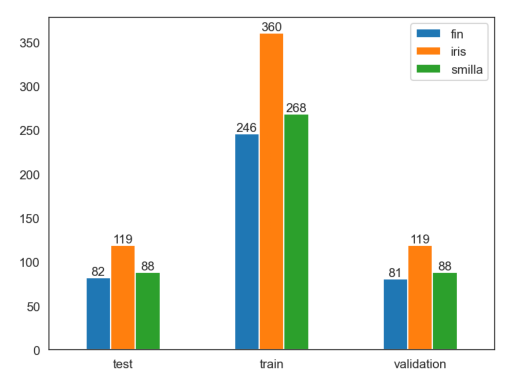

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                        82          246           81
iris                      119          360          119
smilla                     88          268           88


In [5]:
try:
    dataset_stats = joblib.load(f"{output_path}/labels_distribution.pkl")
    dataset_plot = plt.imread(f"{output_path}/labels_distribution_after_split.png")
    plt.imshow(dataset_plot)
    plt.axis('off')
    plt.show()
    df = pd.DataFrame(dataset_stats)
    style_dataframe(df)
    
except FileNotFoundError as e:
    print_err(e=e)

### Calculate augmentation values

In this case, we decide to balance the data through augmentation and oversampling.

*Note:*
Should the application of class weights make more sense for a specific dataset, the following code can be run after the creation of the `y_train` variable and added to the `model.fit()` function as the `class_weight` parameter, to be used with a one-hot encoded list of labels:

```python
    from sklearn.utils import class_weight

    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(weights))
```


In [6]:
from sklearn.preprocessing import normalize


def get_augment_amounts(aug_percentage, stats, batch=None):
    """Calculate augment amounts for each label

    Args:
        aug_percentage (_type_): _description_
        stats (_type_): _description_
        batch (_type_, optional): _description_. Defaults to None.

    Returns:
        _type_: _description_
    """
    
    aug_stats = {}
    df = pd.DataFrame(stats)
    print("Current image distribution in the input dataset:\n")

    max_train_amount = df["train"].max() \
        if (not batch or df["train"].max() < batch) else batch
    max_train_label = df["train"].idxmax()

    style_dataframe(df, max_train_label)

    print(
        f"\nLabel with the most images: {max_train_label} - {df['train'].max()} images\n"
    )
    print(
        f"During the sampling of the original image data, the amount will be 
        f"capped at {Fore.GREEN}{batch}{Fore.RESET}.\n"
    )

    try:
        folders, ratios = joblib.load(f"{output_path}/split_folder_ratio.pkl")
    except FileNotFoundError as e:
        print_err(e=e)

    ratios = normalize([list(ratios)], norm="max").reshape(-1)
    split_ratios = pd.Series(dict(zip(folders, ratios)))
    print(
        f'Normalized split ratios between the train, test, and validation subsets: '
        f'\n{split_ratios.map("{:,.2f}".format).to_string()}'
    )
    max_augment = int(max_train_amount * (1 + aug_percentage))
    print(
        f"\nYou chose to augment the majority label by "
        f"{Fore.GREEN}{aug_percentage*100}%{Fore.RESET}.\n"
        f"After the augmentation, each label in the training set will contain "
        f"{Fore.GREEN}{max_augment}{Fore.RESET} images."
    )

    for col in split_ratios.keys():
        aug_stats[col] = {}
        for idx in df[col].index:
            if batch and df["train"][idx] > batch:
                aug_stats[col][idx] = int(
                    (max_augment - max_train_amount) * split_ratios[col] * -1
                )
            else:
                aug_stats[col][idx] = int(
                    max_augment * split_ratios[col] - df[col][idx]
                )

    print("The following amounts of images need to be added to each label:\n")
    aug_stats = dict(sorted(aug_stats.items(), key=lambda x: x[0]))
    style_dataframe(pd.DataFrame(aug_stats))
    print(
    f"\nIf the amount is negative, the sampling of the original images for "
    f"this label will be \ncapped at {batch} and the label will be augmented "
    f"with the amount shown."
    )

    return aug_stats


`max_label_cap` determines by how many percent the largest label will be augmented.

In [7]:
max_label_cap = 300
aug_stats = get_augment_amounts(1, dataset_stats, batch=max_label_cap)


Current image distribution in the input dataset:

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                        82          246           81
iris                      119          360          119
smilla                     88          268           88

Label with the most images: iris - 360 images

During the sampling of the original image data, the amount will be capped at 300.

Normalized split ratios between the train, test, and validation subsets: 
train         1.00
test          0.33
validation    0.33

You chose to augment the majority label by 100%.
After the augmentation, each label in the training set will contain 600 images.
The following amounts of images need to be added to each label:

                         TEST        TRAIN   VALIDATION
----------------------------------------------------------------------
fin                       118          354          119
iris           

In [12]:

def plot_full_dataset(dataset_stats, aug_stats, LABELS):
    combined_dfs = pd.DataFrame(dataset_stats)
    combined_dfs.loc['iris'] = abs(pd.DataFrame(aug_stats).loc['iris'])
    aug_stats_abs = {
        k: {l: abs(n) for l, n in v.items()} for k, v in aug_stats.items()
        }
    aug_stats_abs = pd.DataFrame(aug_stats_abs)
    combined_dfs = pd.DataFrame(combined_dfs)

    bar_width = 0.2
    x = np.arange(1, len(LABELS)+1)
    colors = {
        'aug': {k: v for k, v in enumerate(['#4670db', '#d49655', '#6ad94e'])},
        'orig': {k: v for k, v in enumerate(['#2f18db', '#d1791d', '#37c912'])}
        }

    for i in range(len(LABELS)):
        plt.bar(x+bar_width*i,
                combined_dfs[combined_dfs.columns].values[i],
                label=f"{combined_dfs.index[i]} orig",
                width=bar_width,
                color=colors['orig'][i])
        plt.bar(x+bar_width*i,
                aug_stats_abs[aug_stats_abs.columns].values[i], 
                bottom=combined_dfs[combined_dfs.columns].values[i],
                label=f"{aug_stats_abs.index[i]} aug",
                width=bar_width,
                color=colors['aug'][i])
        for ix, val1, val2 in zip(
                            x,
                            combined_dfs[combined_dfs.columns].values[:, i],
                            aug_stats_abs[aug_stats_abs.columns].values[:, i]
                            ):
            plt.text(0.5+bar_width+bar_width/4+bar_width*ix+i, val1, str(val1))
            plt.text(0.5+bar_width+bar_width/4+bar_width*ix+i, val2+val1,
                     str(val2))
        
    plt.xticks([1.2,2.2,3.2], labels=combined_dfs.columns)
    plt.legend()
    SAVE = False
    if SAVE:
        plt.savefig(f'{output_path}/post_augment_dataset_plot.png', dpi=150,
                    bbox_inches='tight')
    plt.show()


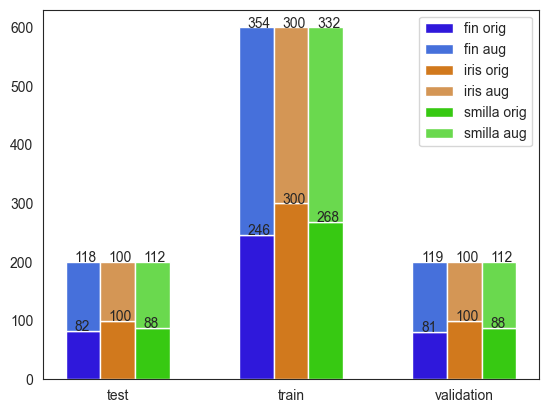

In [13]:

plot_full_dataset(dataset_stats, aug_stats, LABELS)


## Step 2: Load data

In [14]:
# Load all images from specified folder, resize them, save them as np array in X and save their labels in y
from tensorflow.keras.layers import RandomBrightness
import tensorflow as tf


def augment_label(path, subset, extra_amount, X, y, dims, label, img_list):
    print(f"Adding augmented images for label {label} ...")
    extra_list = np.random.choice(img_list, size=extra_amount, replace=True)
    rand_brightness = RandomBrightness([-0.11, 0.11])
    counters = {"brightness": 0, "crop": 0, "hue": 0}

    list_len = len(extra_list)
    progress_bar = show_progress(list_len)

    for img_name in extra_list:
        img = image.load_img(os.path.join(path, label, img_name))

        brightness_adjust = True if random.random() <= 0.6 else False
        crop_adjust = True if random.random() <= 0.6 else False

        if crop_adjust:
            crop_px = random.randint(5, 10)
            offset = random.randint(-2, 2)
            img = img.crop(
                (
                    crop_px + offset,
                    crop_px + offset,
                    dims[0] - (crop_px - offset),
                    dims[1] - (crop_px - offset),
                )
            )
            counters["crop"] += 1
            img = img.resize(dims, resample=Image.LANCZOS)

        img_arr = image.img_to_array(img)

        # Only the train images will be adjusted with noise, random brightness and hue
        if subset == "train":
            if brightness_adjust:
                img_arr = rand_brightness(img_arr).numpy()
                counters["brightness"] += 1

            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Change hue and add noise for each channel
            # Small std means less noise
            std = 0.03
            mean = 0
            for ch in [0, 1, 2]:
                # Add a layer of random noise to each channel
                gaussian = np.random.normal(mean, std, dims)
                hue_changed = False
                if random.random() < 0.25:
                    # 20% chance of not changing hue, only add noise
                    img_arr[:, :, ch] = np.clip(img_arr[:, :, ch] + gaussian, 0, 1)
                    continue

                hue = (
                    random.randrange(-13, 13) / 100.0
                )
                img_flat = img_arr[..., ch].reshape(-1)
                img_hue = np.array([x + hue for x in img_flat]).reshape(dims)
                img_arr[..., ch] = np.clip(img_hue + gaussian, 0, 1)
                hue_changed = True

            if hue_changed:
                counters["hue"] += 1
        else:
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

        print(next(progress_bar), end="")

        X = np.append(X, img_arr)
        y = np.append(y, label)

    return X, y, counters, list_len

In [62]:
def save_images_in_array(path, subset, aug_stats, max_label_cap, shape):
    X, y = np.array([], dtype="int"), np.array([], dtype="object")
    dims = tuple(shape[1:3])

    for label in os.listdir(path):
        print(f"Loading original images for label {label} ...")
        img_list = os.listdir(os.path.join(path, label))
        aug_amount = aug_stats[subset][label]

        try:
            folders, ratios = joblib.load(f"{output_path}/split_folder_ratio.pkl")
        except FileNotFoundError as e:
            print_err(e=e)

        ratios = normalize([list(ratios)], norm="max").reshape(-1)
        split_ratios = dict(zip(folders, ratios))
        # Undersample labels that are too large
        if aug_amount < 0:
            img_list = random.sample(
                img_list, k=int(max_label_cap * split_ratios[subset])
            )

        list_len = len(img_list)
        progress_bar = show_progress(list_len)

        for img_name in img_list:
            img = image.load_img(os.path.join(path, label, img_name))
            img_arr = image.img_to_array(img)
            if img_arr.max() > 1:
                img_arr = img_arr / 255.0

            # Add noise to train image set
            if subset == "train":
                std = 0.03
                mean = 0
                gaussian = np.random.normal(mean, std, dims)
                noisy_image = np.zeros(img_arr.shape, np.float32)
                for ch in [0, 1, 2]:
                    noisy_image[:, :, ch] = img_arr[:, :, ch] + gaussian
                img_arr = np.clip(noisy_image, 0, 1).astype(np.float32)

            print(next(progress_bar), end="")

            X = np.append(X, img_arr)
            y = np.append(y, label)

        print(f"{list_len} images loaded")

        # Augment images:
        X, y, counters, aug_count = augment_label(
            path, subset, abs(aug_amount), X, y, dims, label, img_list
        )

        print(f"{aug_count} images loaded")

        print(
            f'\nAugmented label {label} by cropping {counters["crop"]} images, '
            f'adjusting brightness for {counters["brightness"]} images and '
            f'\nchanging hue for {counters["hue"]} images. '
            f'{"Noise has been added to all images." if subset == "train" else ""}'
        )
        print(
            f"The {subset} subset for {label} contains {list_len + aug_count} images.\n"
        )

    X = X.reshape(shape)

    # SMOTENC oversampling not useable: too many errors in the resulting images

    # Shuffle the resulting set
    zipped_set = list(zip(y, X))
    random.shuffle(zipped_set)
    y_shuffled, X_shuffled = list(map(list, zip(*zipped_set)))
    X = np.array(X_shuffled, dtype="float")
    y = np.array(y_shuffled, dtype="object")

    print(f"Resulting image set shape: {X.shape}, {y.shape} labels\n")

    return X, y

### Load train set

In [63]:
# Recreate the training set:
X_train, y_train = save_images_in_array(
    train_path, "train", aug_stats, max_label_cap, INPUT_SHAPE
)

Loading original images for label fin ...
####################################################################################################|| 246 images loaded
Adding augmented images for label fin ...
####################################################################################################|| 294 images loaded

Augmented label fin by cropping 172 images, adjusting brightness for 197 images and 
changing hue for 218 images. Noise has been added to all images.
The train subset for fin contains 540 images.

Loading original images for label iris ...
####################################################################################################|| 360 images loaded
Adding augmented images for label iris ...
####################################################################################################|| 180 images loaded

Augmented label iris by cropping 111 images, adjusting brightness for 94 images and 
changing hue for 139 images. Noise has been added to all image

#### Save train set shape

In [64]:
joblib.dump(X_train.shape, f"{output_path}/input_shape_loaded.pkl")

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/input_shape_loaded.pkl']

#### Show montage

In [65]:
import itertools


def show_subset_montage(X, y, subset, save=False):
    # Display a random batch of k images from the newly created subset
    img_sample = random.sample(range(0, X.shape[0]), k=9)
    coords = list(itertools.product(range(3), range(3)))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    for coord, idx in zip(coords, list(img_sample)):
        axes[coord[0], coord[1]].set_title(y[idx])
        axes[coord[0], coord[1]].imshow(X[idx])
        set_ticks(axes[coord[0], coord[1]])
    plt.tight_layout(rect=[0, 0.02, 0.9, 0.97])
    if save:
        plt.savefig(
            f"{output_path}/post_augment_montage_{subset}.png",
            bbox_inches="tight",
            dpi=150,
        )
    plt.show()

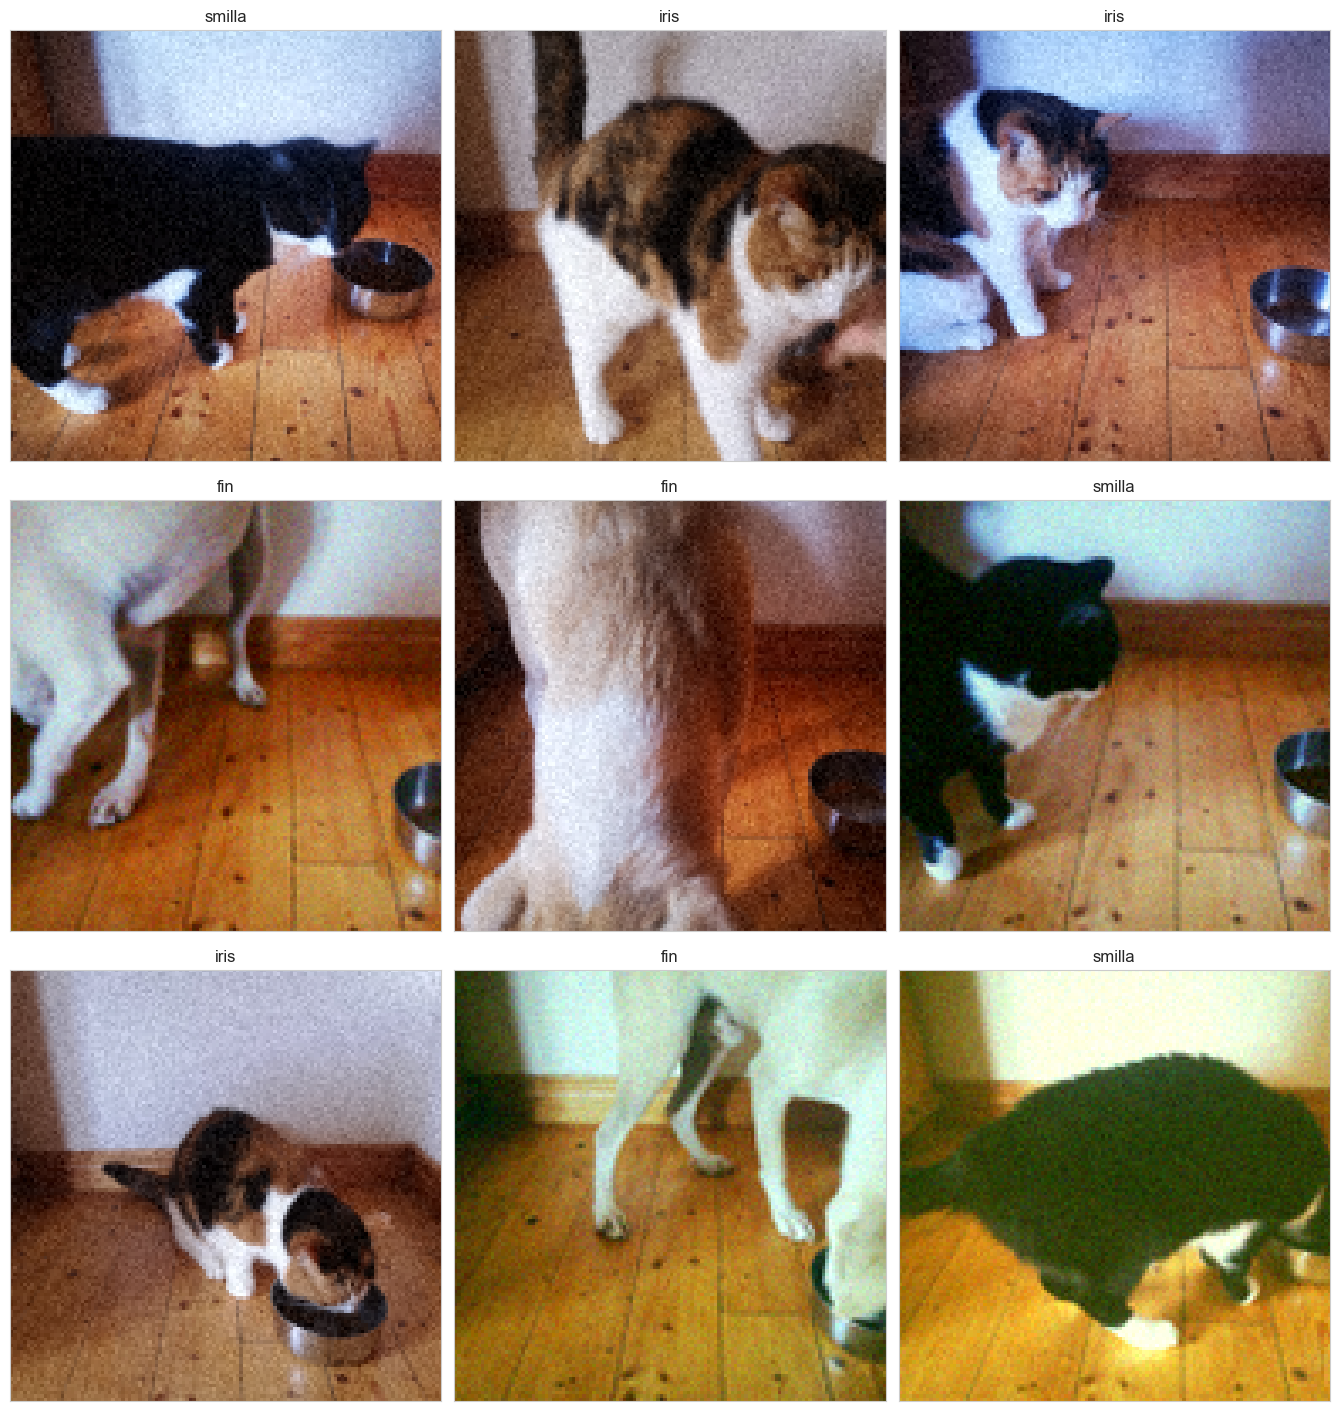

In [66]:
show_subset_montage(X_train, y_train, "train")

### Load all other subsets

In [67]:
X_test, y_test = save_images_in_array(
    test_path, "test", aug_stats, max_label_cap, INPUT_SHAPE
)
X_val, y_val = save_images_in_array(
    validation_path, "validation", aug_stats, max_label_cap, INPUT_SHAPE
)

Loading original images for label fin ...
####################################################################################################|| 82 images loaded
Adding augmented images for label fin ...
####################################################################################################|| 98 images loaded

Augmented label fin by cropping 59 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for fin contains 180 images.

Loading original images for label iris ...
####################################################################################################|| 119 images loaded
Adding augmented images for label iris ...
####################################################################################################|| 60 images loaded

Augmented label iris by cropping 41 images, adjusting brightness for 0 images and 
changing hue for 0 images. 
The test subset for iris contains 179 images.

Loading original images for label

#### Show montages

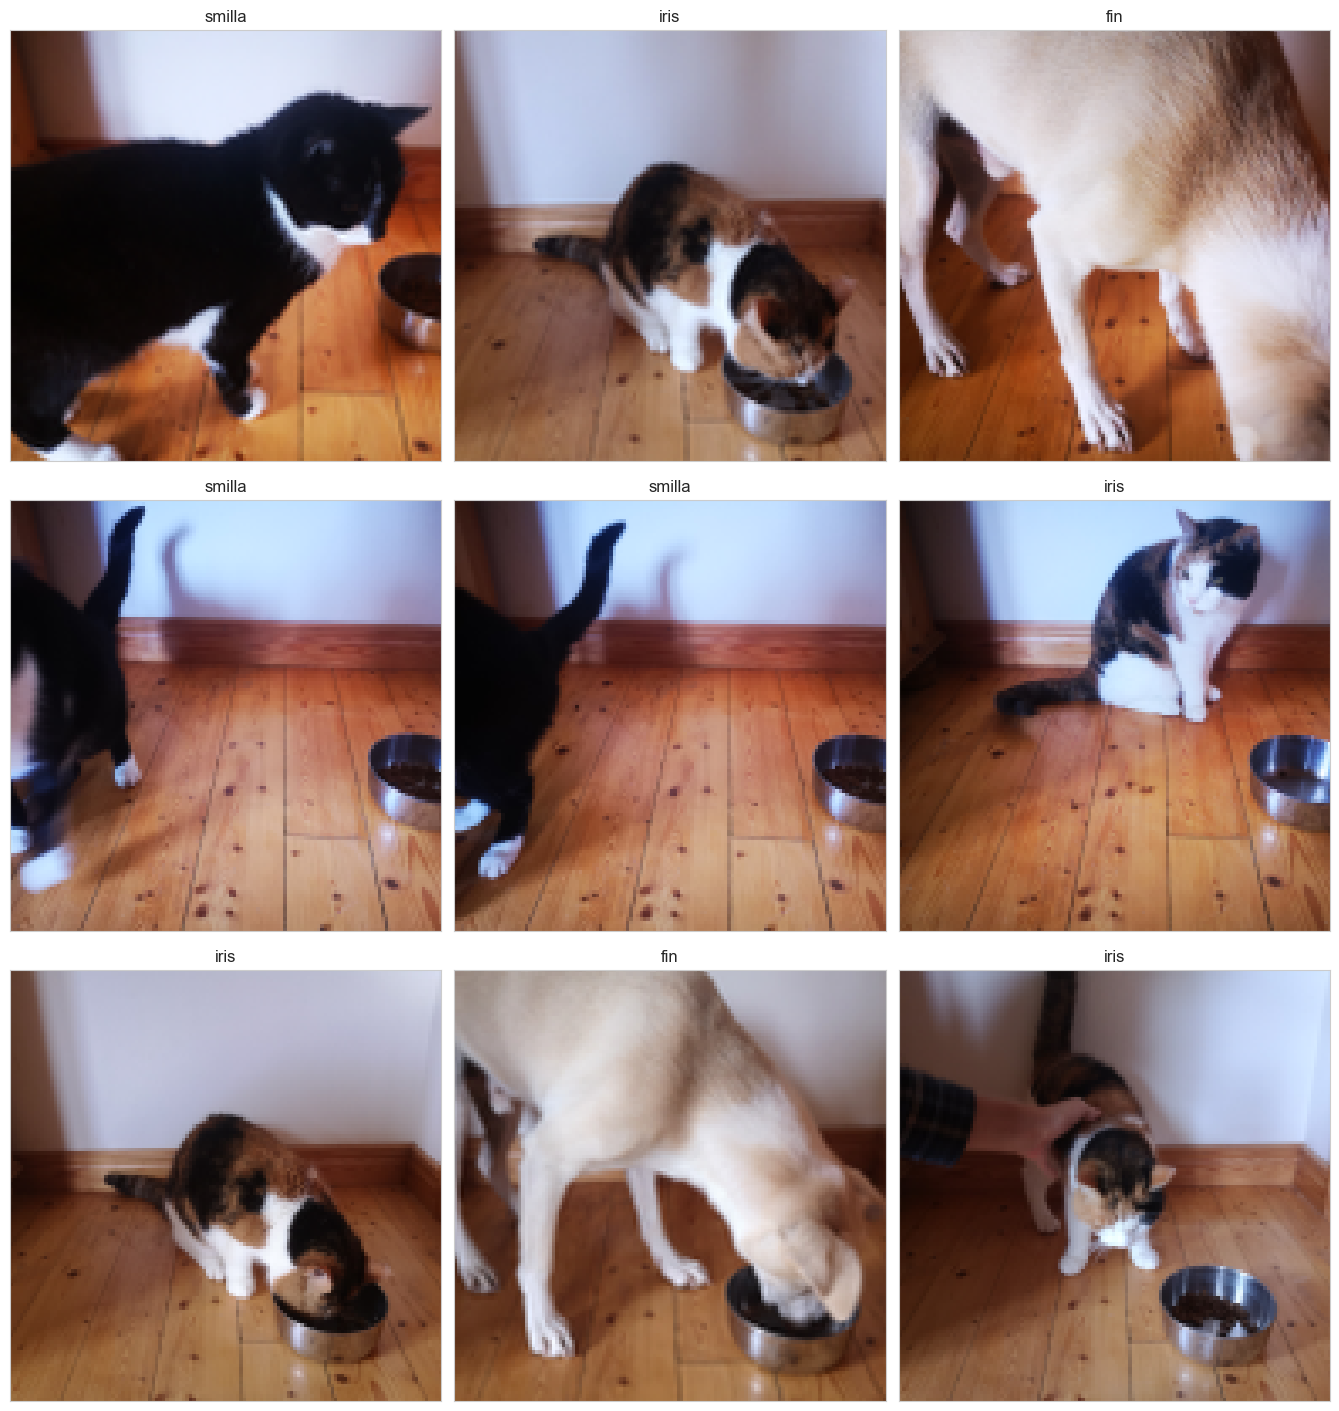

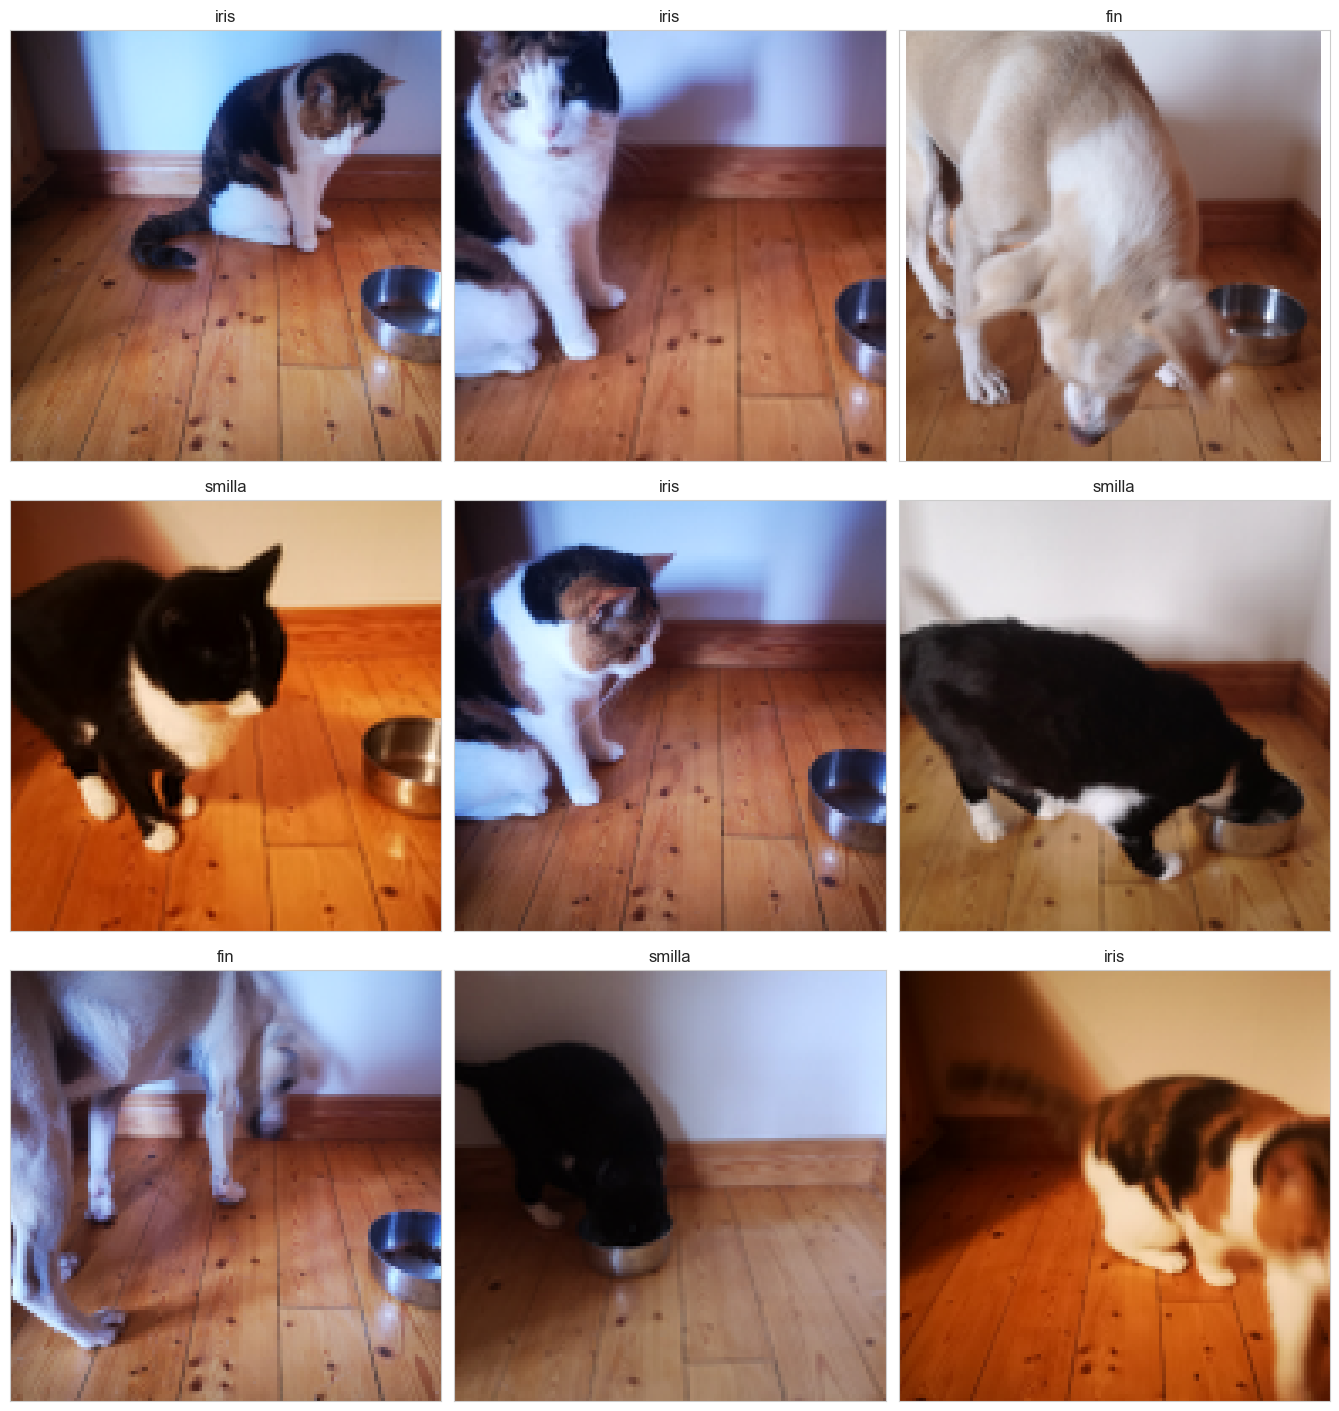

In [68]:
# Display a random batch of k images from the newly created validation and test sets
show_subset_montage(X_val, y_val, "val")
show_subset_montage(X_test, y_test, "test")

### One-hot encode all label arrays

In [69]:
y_ohe_train = pd.get_dummies(y_train, dtype="int")
y_ohe_test = pd.get_dummies(y_test, dtype="int")
y_ohe_val = pd.get_dummies(y_val, dtype="int")

# Check if the encoding has succeeded
print(y_ohe_train.head())
print(y_ohe_test.head())
print(y_ohe_val.head())

# Save the one-hot encoded categories for later use
ohe_enc = pd.get_dummies(LABELS, dtype="int")
ohe_map = {}
for idx, label in CLASS_DICT.items():
    ohe_map[label] = list(ohe_enc.iloc[idx])
joblib.dump(ohe_map, f"{output_path}/ohe_map.pkl")
print(ohe_map)

   fin  iris  smilla
0    1     0       0
1    1     0       0
2    1     0       0
3    1     0       0
4    0     1       0
   fin  iris  smilla
0    0     0       1
1    0     0       1
2    0     0       1
3    0     1       0
4    1     0       0
   fin  iris  smilla
0    0     1       0
1    0     1       0
2    1     0       0
3    0     0       1
4    0     1       0
{'fin': [1, 0, 0], 'iris': [0, 1, 0], 'smilla': [0, 0, 1]}


### (Optional) Save and load subsets

#### Save subsets and labels to files

In [71]:
v = 'x_full'

def save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val):
    joblib.dump(X_train, f"{output_path}/X_train_{v}.pkl")
    joblib.dump(X_test, f"{output_path}/X_test_{v}.pkl")
    joblib.dump(X_val, f"{output_path}/X_val_{v}.pkl")
    joblib.dump(y_ohe_train, f"{output_path}/y_ohe_train_{v}.pkl")
    joblib.dump(y_ohe_test, f"{output_path}/y_ohe_test_{v}.pkl")
    joblib.dump(y_ohe_val, f"{output_path}/y_ohe_val_{v}.pkl")


save_subsets_and_labels(X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val)

#### Load subsets and labels from files

In [12]:
# Load the image sets and OHE labels into memory if they already have been created:

def load_subsets_and_labels():
    v = '_x_balanced'
    out = 'D:/Projekte/Coding/CodeInstitute/PP5_storage/from final output/'
    X_train = joblib.load(f"{out}/dataset_files/X_train{v}.pkl")
    X_test = joblib.load(f"{out}/dataset_files/X_test{v}.pkl")
    X_val = joblib.load(f"{out}/dataset_files/X_val{v}.pkl")
    y_ohe_train = joblib.load(f"{out}/dataset_files/y_ohe_train{v}.pkl")
    y_ohe_test = joblib.load(f"{out}/dataset_files/y_ohe_test{v}.pkl")
    y_ohe_val = joblib.load(f"{out}/dataset_files/y_ohe_val{v}.pkl")

    return X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val


X_train, X_test, X_val, y_ohe_train, y_ohe_test, y_ohe_val = load_subsets_and_labels()

## Step 3: Build the model

In [13]:
import tensorflow as tf
import keras_tuner
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dropout,
    Flatten,
    Dense,
    Conv2D,
    MaxPooling2D,
    InputLayer,
)
from tensorflow.keras.callbacks import EarlyStopping

In [273]:
# Optimize hyperparams
def test_model(hp):
    img_shape = (128, 128, 3)
    output_classes = 3

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    kern = hp.Int("kernel_1", min_value=3, max_value=6, step=1)
    model.add(
        Conv2D(
            filters=hp.Int("filters_1", min_value=32, max_value=256, step=32),
            kernel_size=(kern, kern),
            padding="same",
            activation="relu",
        )
    )
    pool = hp.Int("pool_1", min_value=2, max_value=5, step=1)
    model.add(MaxPooling2D(pool_size=(pool, pool)))

    model.add(
        Conv2D(
            filters=hp.Int("filters_2", min_value=64, max_value=256, step=32),
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Optional third filter layer
    for i in range(0, hp.Int("third_filter", 0, 1)):
        model.add(
            Conv2D(
                filters=hp.Int(
                    "filters_3_" + str(i), min_value=128, max_value=256, step=32
                ),
                kernel_size=(3, 3),
                padding="same",
                activation="relu",
            )
        )
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(
        Dense(
            hp.Int("dense_units_1", min_value=128, max_value=1024, step=64),
            activation="relu",
        )
    )
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.6, step=0.1)))

    # Optional second dense layer
    for i in range(0, hp.Int("second_dense_layer", 0, 1)):
        model.add(
            Dense(
                hp.Int("dense_units_2", min_value=64, max_value=256, step=32),
                activation="relu",
            )
        )
        model.add(
            Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.5, step=0.1))
        )

    model.add(Dense(output_classes, activation="softmax"))

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-1, 1e-2, 1e-3, 1e-4])
    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        metrics=["accuracy"],
    )

    model.summary()

    return model

### Tune model

In [123]:
early_stop = EarlyStopping(monitor="val_loss", patience=5,  restore_best_weights=True,
    start_from_epoch=5,)

hp = keras_tuner.HyperParameters()
model = test_model(hp)

batch_size = 32

tuner = keras_tuner.BayesianOptimization(
    test_model,
    max_trials=20,
    objective="val_accuracy",
    directory="/tmp/tb",
    project_name="pets",
)

tuner.search(
    X_train,
    y_ohe_train,
    validation_data=(X_val, y_ohe_val),
    epochs=30,
    batch_size=batch_size,
    callbacks=[early_stop],
)

Trial 1 Complete [00h 03m 45s]
val_accuracy: 0.9558498859405518

Best val_accuracy So Far: 0.9558498859405518
Total elapsed time: 00h 03m 45s


### Save hyperparameters

In [18]:
best_model = tuner.get_best_models(num_models=1)[0]

best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(pd.Series(best_hyperparameters.values).to_string())
hyperparams = best_hyperparameters.values
joblib.dump(hyperparams, f'{final_model}/hyperparam_values_{v}.pkl')
print(pd.Series(hyperparams).to_string())

kernel_1           5.0000
filters_1        128.0000
pool_1             6.0000
filters_2        128.0000
filters_3        128.0000
dense_units_1    384.0000
dropout_1          0.3000
learning_rate      0.0010
kernel_reg         0.0001


### (Optional) Load pre-saved hyperparameter values

In [26]:
hyperparams = joblib.load(f"{output_path}/hyperparam_values.pkl")
print(pd.Series(hyperparams))

kernel_1           6.000
filters_1        128.000
pool_1             5.000
filters_2        128.000
num_filters        1.000
dense_units_1    384.000
dropout_1          0.600
learning_rate      0.001
filters_3_0      128.000
dtype: float64


## Step 4: Train the model

### Adapt and compile model

In [274]:
# Prepare model for saved hyperparams
def create_model(hyperparams):
    img_shape = INPUT_SHAPE[1:]
    output_classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    model.add(
        Conv2D(
            filters=hyperparams["filters_1"],
            kernel_size=(hyperparams["kernel_1"], hyperparams["kernel_1"]),
            padding="same",
            activation="relu",
        )
    )
    model.add(MaxPooling2D(pool_size=(hyperparams["pool_1"], hyperparams["pool_1"])))

    model.add(
        Conv2D(
            filters=hyperparams["filters_2"],
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(
            filters=hyperparams["filters_3"],
            kernel_size=(3, 3),
            padding="same",
            activation="relu",
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hyperparams["dense_units_1"], activation="relu"))
    model.add(Dropout(hyperparams["dropout_1"]))

    model.add(Dense(output_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hyperparams["learning_rate"]),
        metrics=["accuracy"],
    )

    model.summary()

    return model

In [321]:
from tensorflow.keras.regularizers import l2


# Prepare model for saved hyperparams
def create_model(hyperparams):
    img_shape = INPUT_SHAPE[1:]
    output_classes = len(LABELS)

    model = Sequential()
    model.add(InputLayer(shape=img_shape))

    model.add(
        Conv2D(
            filters=hyperparams["filters_1"],
            kernel_size=(hyperparams["kernel_1"], hyperparams["kernel_1"]),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(hyperparams["pool_1"], hyperparams["pool_1"])))

    model.add(
        Conv2D(
            filters=hyperparams["filters_2"],
            kernel_size=(3, 3),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(
        Conv2D(
            filters=hyperparams["filters_3"],
            kernel_size=(3, 3),
            activation="relu",
            padding='same',
            kernel_regularizer=l2(hyperparams['kernel_reg']),
        )
    )
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hyperparams["dense_units_1"], activation="relu", kernel_regularizer=l2(hyperparams['kernel_reg'])))
    model.add(Dropout(hyperparams["dropout_1"]))

    model.add(Dense(output_classes, activation="softmax"))

    model.compile(
        loss="categorical_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=hyperparams["learning_rate"]),
        metrics=["accuracy"],
    )

    model.summary()

    return model

### Fit the model

In [340]:
early_stop = EarlyStopping(monitor="val_loss", patience=5,
                           restore_best_weights=True,
                           start_from_epoch=5,)

batch_size = 32

model = create_model(hyperparams)


history = model.fit(
    X_train,
    y_ohe_train,
    epochs=40,
    validation_data=(X_val, y_ohe_val),
    verbose=1,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop]
)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072,451 (7.91 MB)

 Trainable params: 2,072,451 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 41s 665ms/step - accuracy: 0.5191 - loss: 0.9934 - val_accuracy: 0.9133 - val_loss: 0.2912
Epoch 2/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 620ms/step - accuracy: 0.9248 - loss: 0.2910 - val_accuracy: 0.9467 - val_loss: 0.1736
Epoch 3/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 613ms/step - accuracy: 0.9478 - loss: 0.1868 - val_accuracy: 0.9750 - val_loss: 0.1285
Epoch 4/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 666ms/step - accuracy: 0.9714 - loss: 0.1337 - val_accuracy: 0.9583 - val_loss: 0.1437
Epoch 5/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 42s 733ms/step - accuracy: 0.9864 - loss: 0.0908 - val_accuracy: 0.9467 - val_loss: 0.1719
Epoch 6/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 39s 681ms/step - accuracy: 0.9887 - loss: 0.0767 - val_accuracy: 0.9450 - val_loss: 0.1669
Epoch 7/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 657ms/step - accuracy: 0.9952 - loss: 0.0576 - val_accuracy: 0.9650 - val_loss: 0.1766
Epoch 8/40
57/57 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.9913 - loss: 0.0705 - val_accu

### Identify best epoch

In [386]:
val_acc_per_epoch = history.history["val_accuracy"]
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print(f"Best epoch: {best_epoch}")

Best epoch: 7


### Retrain model

If the last epoch was not the best, retrain the model and stop at the best epoch.

In [ ]:
print(joblib.load('outputs/hyperparam_values.pkl'))


In [343]:
model = create_model(hyperparams)


history = model.fit(
    X_train,
    y_ohe_train,
    epochs=best_epoch,
    validation_data=(X_val, y_ohe_val),
    verbose=1,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[early_stop]
)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 128)  │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 384)            │     1,769,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,072,451 (7.91 MB)

 Trainable params: 2,072,451 (7.91 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 704ms/step - accuracy: 0.5687 - loss: 0.9386 - val_accuracy: 0.8883 - val_loss: 0.3572
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 622ms/step - accuracy: 0.9208 - loss: 0.3075 - val_accuracy: 0.9600 - val_loss: 0.1892
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 35s 621ms/step - accuracy: 0.9599 - loss: 0.1639 - val_accuracy: 0.9650 - val_loss: 0.1463
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 640ms/step - accuracy: 0.9847 - loss: 0.0946 - val_accuracy: 0.9750 - val_loss: 0.1123
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 704ms/step - accuracy: 0.9888 - loss: 0.0876 - val_accuracy: 0.9767 - val_loss: 0.0973
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 40s 699ms/step - accuracy: 0.9932 - loss: 0.0687 - val_accuracy: 0.9633 - val_loss: 0.1240
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 766ms/step - accuracy: 0.9899 - loss: 0.0771 - val_accuracy: 0.9850 - val_loss: 0.0980
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - accuracy: 0.9996 - loss: 0.0549 - val_accu

### Save the model

In [344]:
####################### VERSIONING
v = 'XX'  # used!
model.save(f"{output_path}/model_final_{v}.keras")

### (Optional) Load pre-saved model

In [60]:
#model = tf.keras.models.load_model(f"{output_path}/model_final.keras")
v = '_x_b_1'
model = tf.keras.models.load_model(f"{final_model}/model_final_x_b_1.keras")


In [ ]:
model.get_config()

In [26]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_path = f'{final_model}/model_x_b_1.tflite'
# Save the TFLite model as a .tflite file
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355\assets


INFO:tensorflow:Assets written to: C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355\assets


Saved artifact at 'C:\Users\Public\Documents\Wondershare\CreatorTemp\tmp5rtwv355'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='input_layer_16')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1473305798096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305797520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305794640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305800208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472054067856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473305795408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473298374608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1473299328720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472064928272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1472063406160: TensorSpec(shape=(), dtype=tf.resource, 

In [11]:
# Load TFLite model and allocate tensors
tflite_path = f'{final_model}/model_x_b_1.tflite'

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)

# Test the model on random input data
input_index = input_details[0]['index']
output_index = output_details[0]['index']

[{'name': 'serving_default_input_layer_16:0', 'index': 0, 'shape': array([  1, 128, 128,   3]), 'shape_signature': array([ -1, 128, 128,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall_1:0', 'index': 21, 'shape': array([1, 3]), 'shape_signature': array([-1,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [13]:
int_data = (interpreter, input_index, output_index)

In [26]:
def tflite_predict(imgs, interpreter, input_index, output_index):
    """_summary_

    Args:
        imgs (_type_): _description_
        interpreter (_type_): _description_
        input_index (_type_): _description_
        output_index (_type_): _description_

    Returns:
        _type_: _description_
    """
    ################################## tflite prediction
    y_pred_raw = np.array([])
    for img in imgs:
        input_data = np.expand_dims(img.astype('float32'), axis=0)
        interpreter.set_tensor(input_index, input_data)

        # Run the inference
        interpreter.invoke()

        # Get the results
        output_data = interpreter.get_tensor(output_index)
        if len(y_pred_raw) == 0:
            y_pred_raw = output_data
        else:
            y_pred_raw = np.vstack((y_pred_raw, output_data))
            #y_pred.extend(output_data)
    return y_pred_raw
    ##################################

## Step 5: Evaluate model

### Compare losses and accuracy

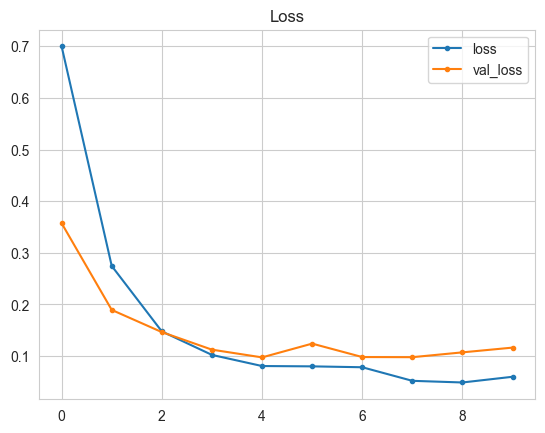

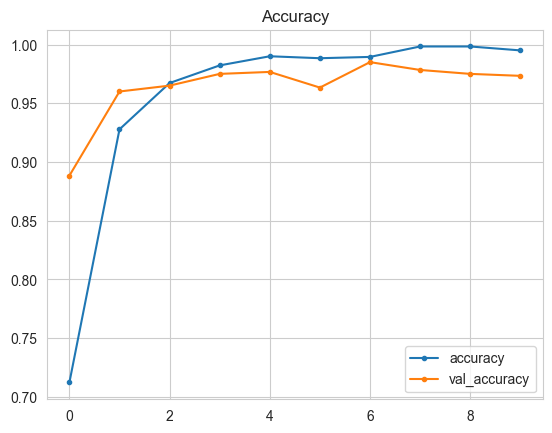

In [368]:
losses = pd.DataFrame(history.history)

sns.set_style("whitegrid")
losses[["loss", "val_loss"]].plot(style=".-")
plt.title("Loss")

if SAVE:
    plt.savefig(f"{output_path}/model_losses_{v}.png", bbox_inches="tight", dpi=150)
plt.show()

print("\n")
losses[["accuracy", "val_accuracy"]].plot(style=".-")
plt.title("Accuracy")

if SAVE:
    plt.savefig(f"{output_path}/model_acc_{v}.png", bbox_inches="tight", dpi=150)
plt.show()

### Evaluate based on test subset

In [24]:
eval = model.evaluate(X_test, y_ohe_test, verbose=2)
eval

19/19 - 5s - 247ms/step - accuracy: 0.9850 - loss: 0.1052


[0.10516383498907089, 0.9850000143051147]

In [372]:
joblib.dump(eval, f"{output_path}/model_final_eval_{v}.pkl")

[0.10516383498907089, 0.9850000143051147]

## Step 6: Make predictions
### Predict classes for a test image sample

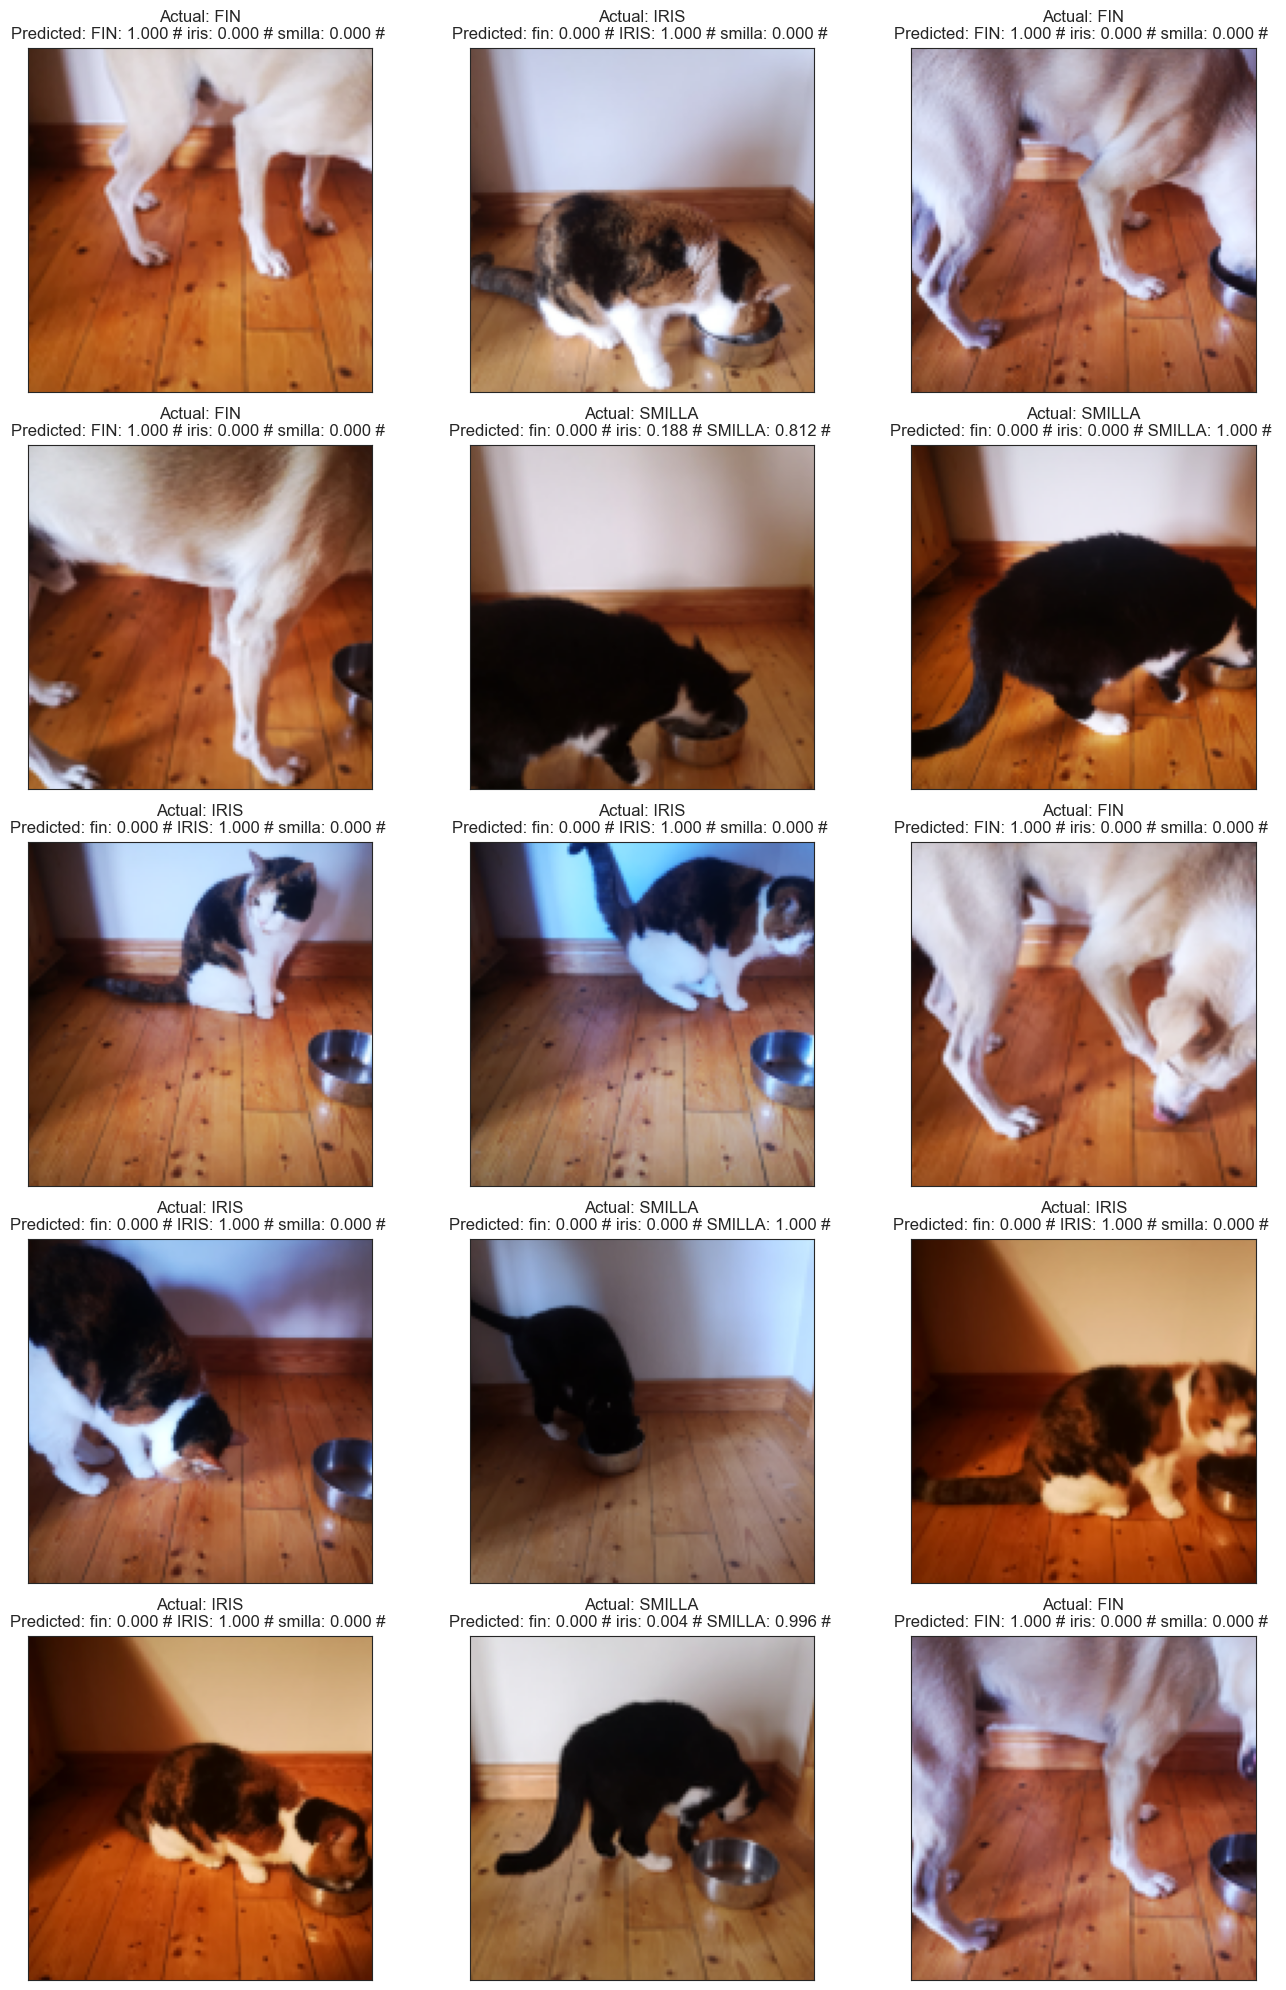

In [21]:
import itertools
sns.set_style("white")
# Figure properties
# Note: sample amount must be divisible by 3 to fit into three columns
sample_amount = 15
nrows = sample_amount // 3
coords = itertools.product(range(nrows), range(3))
# Sample random images and assign correct labels
img_idx = random.sample(range(0, X_test.shape[0]), k=sample_amount)
sample_imgs = np.array([X_test[i] for i in img_idx])
y_true = [y_ohe_test.loc[i].idxmax() for i in img_idx]
# Predict the classes of the sample images

y_pred = model.predict(sample_imgs, verbose=3)
#y_pred = tflite_predict(sample_imgs, *int_data)

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))
for coord, label, pred, img in zip(coords, y_true, y_pred, sample_imgs):
    title_str = f"Actual: {label.upper()}\nPredicted: "
    for i, cl in CLASS_DICT.items():
        title_str += f"{cl.upper() if pred[i]==pred.max() else cl}: {pred[i]:.3f} # "
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(img)
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
if SAVE:
    plt.savefig(f"{output_path}/pred_test_montage.png")
plt.show()

### Evaluate the test subset class predictions

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

Create a confusion matrix and a classification report for the test images.

In [40]:
# Create numpy array with test image class predictions

#################
y_pred_raw = model.predict(X_test, verbose=3)
#################
######################### Using the tflite model for inference
y_pred_raw = tflite_predict(X_test, *int_data)

# Transform into a DataFrame with class names
y_pred = pd.DataFrame(
    [CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)], columns=[""]
)
# Get a DataFrame with the actual class names
y_true = pd.from_dummies(y_ohe_test)

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print("\nConfusion matrix: \n")
print(conf_matrix)
print("\nClassification report: \n")
print(class_report)

if SAVE:
    joblib.dump(
        f"Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}",
        f"{output_path}/test_class_report_{v}.pkl",
    )


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               197               3                 0
Actually iris                2             195                 3
Actually smilla              0              11               189

Classification report: 

              precision    recall  f1-score   support

         fin       0.99      0.98      0.99       200
        iris       0.93      0.97      0.95       200
      smilla       0.98      0.94      0.96       200

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



### Precision heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


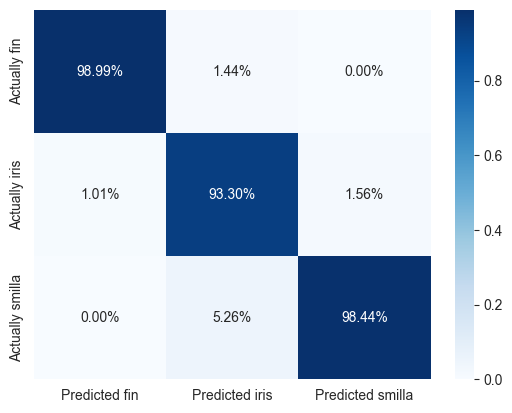

In [41]:
# Show precision in heat map
SAVE = True
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m / np.sum(c_m), annot=True, fmt=".2%", cmap="Blues")

if SAVE:
    plt.savefig(f"{mod}/pred_test_precision_heatmap_{v}.png")
plt.show()

### Overall classification heatmap

In [42]:
# Prepare classification report for heatmap visualization
cr = classification_report(y_true, y_pred, target_names=LABELS, output_dict=True)
df_cr = pd.DataFrame.from_dict(cr)
df_cr.drop(index=["support"], axis=0, inplace=True)
df_cr.drop(columns=["macro avg", "weighted avg", "accuracy"], axis=1, inplace=True)
df_cr = df_cr.apply(lambda x: x * 100)

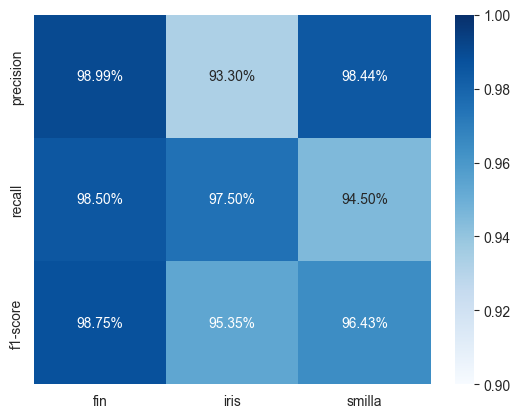

In [43]:
# Show precision in heat map
sns.heatmap(df_cr / 100, annot=True, fmt=".2%", cmap="Blues", vmin=0.9, vmax=1)
if SAVE:
    plt.savefig(f"{mod}/pred_test_classification_heatmap_{v}.png")
plt.show()

### Images that were falsely classified

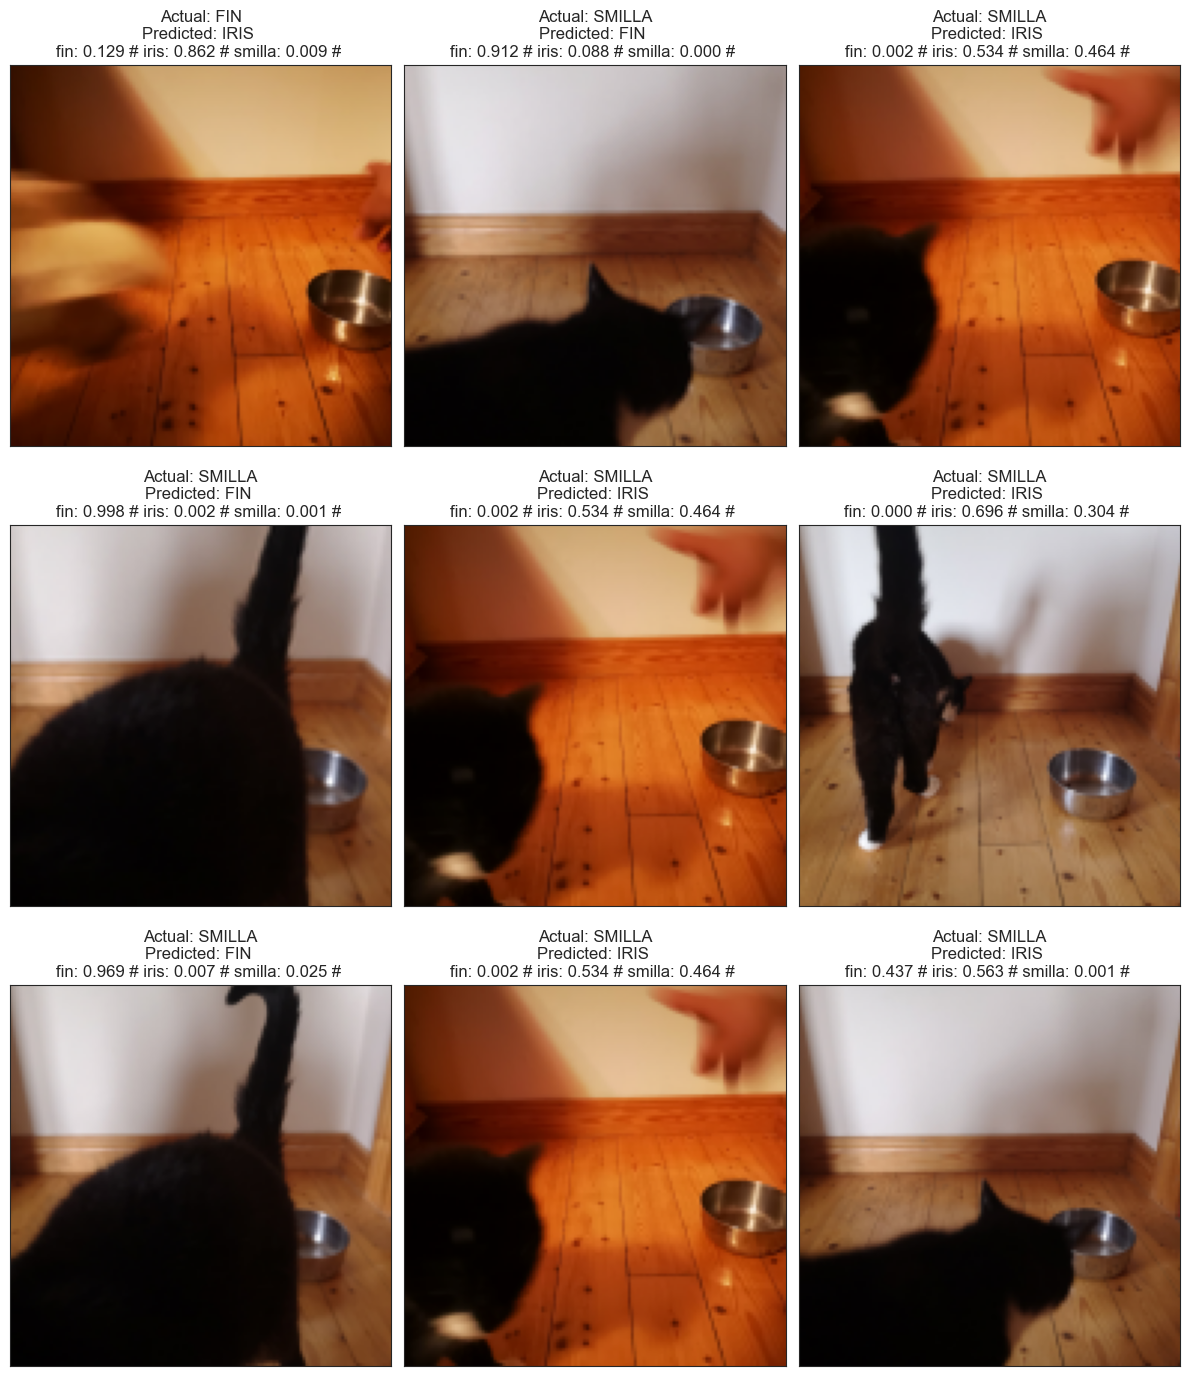

In [39]:
import itertools
# Compare both DataFrames
diff = y_true.compare(y_pred)
diff.sort_values(by=("", "self"), axis=0, inplace=True)
diff_label_pairs = np.array(diff)
diff_len = len(diff_label_pairs)
# Figure properties
nrows = diff_len // 3 + (1 if diff_len % 3 else 0)
coords = list(itertools.product(range(nrows), range(3)))[:diff_len]

fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, nrows * 5))
for ax in axes.flatten():
    ax.axis("off")
for coord, idx, labs in zip(coords, diff.index, diff_label_pairs):
    title_str = f"Actual: {labs[0].upper()}\nPredicted: {labs[1].upper()} \n"
    for i, cl in CLASS_DICT.items():
        title_str += f"{cl}: {y_pred_raw[idx][i]:.3f} # "
    axes[coord[0], coord[1]].set_title(title_str)
    axes[coord[0], coord[1]].imshow(X_test[idx])
    set_ticks(axes[coord[0], coord[1]])
plt.tight_layout(rect=[0, 0.05, 0.8, 0.98])
if SAVE:
    plt.savefig(f"{output_path}/pred_diff_test_montage_{v}.png")
plt.show()

### Images with low confidence

('fin', 'smilla', 'smilla', 'smilla', 'smilla')


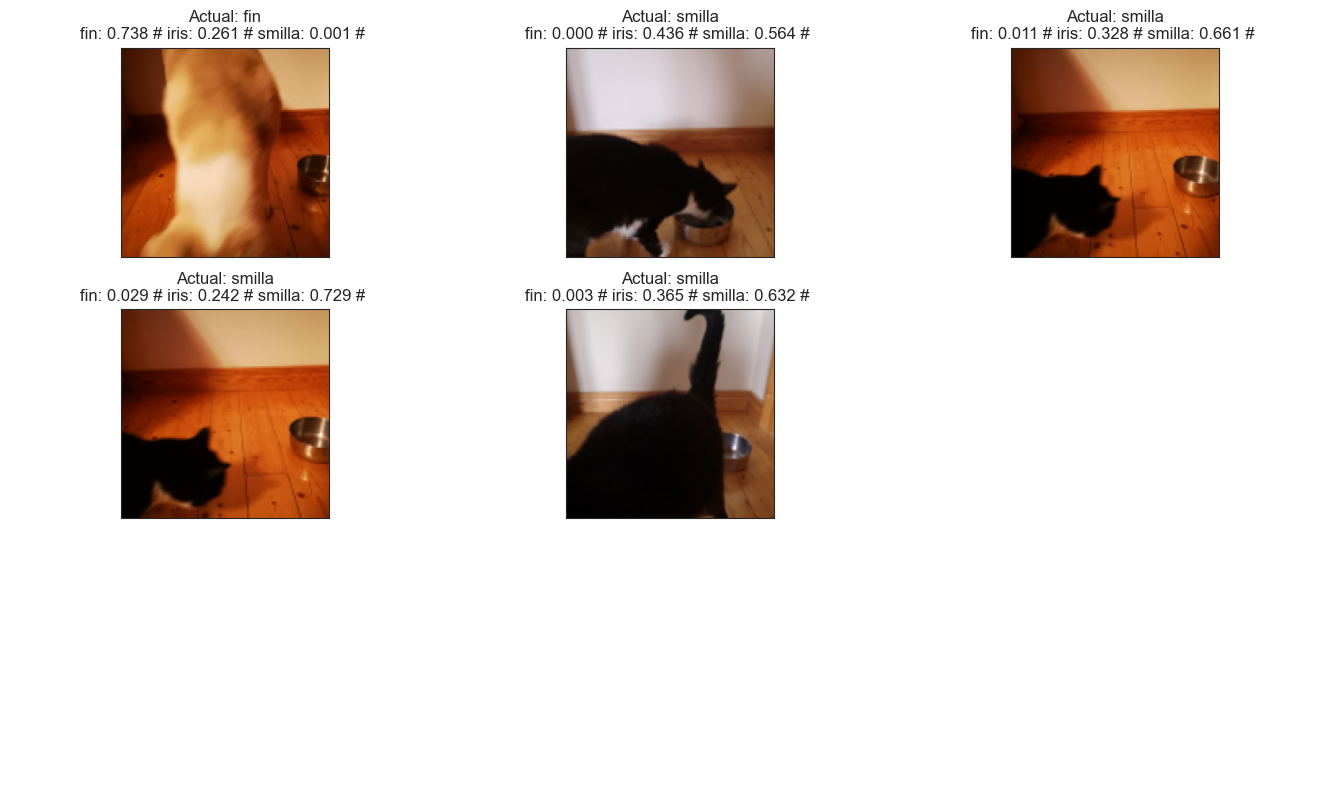

In [354]:

max_vals = y_pred_raw.max(axis=1)
unsure_idx = np.argwhere(max_vals < 0.75).flatten()
unsure_idx = [x for x in unsure_idx if x not in list(diff.index)]
all_labels = y_true.to_numpy().flatten()
unsure_labels = [all_labels[i] for i in unsure_idx]
if unsure_labels:
    unsure_idx, unsure_labels = list(
        zip(*sorted(zip(unsure_idx, unsure_labels), key=lambda x: x[1]))
    )
    unsure_len = len(unsure_idx)
    nrows = unsure_len // 3 + (1 if unsure_len % 3 else 0)
    coords = list(itertools.product(range(nrows), range(3)))[:unsure_len]
    print(unsure_labels)
    fig, axes = plt.subplots(nrows=nrows+1, ncols=3, figsize=(15, nrows * 5))
    for ax in axes.flatten():
        ax.axis("off")
    for coord, idx, labs in zip(coords, unsure_idx, unsure_labels):
        title_str = f"Actual: {labs}\n"
        for i, cl in CLASS_DICT.items():
            title_str += f"{cl}: {y_pred_raw[idx][i]:.3f} # "
        axes[coord[0], coord[1]].set_title(title_str)
        axes[coord[0], coord[1]].imshow(X_test[idx])
        set_ticks(axes[coord[0], coord[1]])
    plt.tight_layout(rect=[0, 0.1, 0.9, 0.9])
    if SAVE:
        plt.savefig(f"{output_path}/pred_unsure_test_montage_{v}.png")
    plt.show()

### Test model with live data

In [31]:
from PIL.Image import UnidentifiedImageError


def save_live_data(path, shape):
    Xy_dict = {}
    dims = shape[1:3]
    for label in os.listdir(path):
        img_list = os.listdir(os.path.join(path, label))
        Xy_dict[label] = np.array([], dtype="int")

        print(f'\nImporting from label "{label}..."')
        progress_bar = show_progress(list_len=len(img_list), label=label)
        img_counter = 0
        errors = []

        for img_name in img_list:
            try:
                img = image.load_img(os.path.join(path, label, img_name))
            except UnidentifiedImageError as e:
                errors.append(f"{e} :: {img_name} >> skipped")
                continue
            if img.size != (dims):
                img = img.resize(dims, resample=Image.LANCZOS)
            img_resized = image.img_to_array(img)
            if img_resized.max() > 1:
                img_resized = img_resized / 255

            img_counter += 1
            Xy_dict[label] = np.append(Xy_dict[label], img_resized)

            print(next(progress_bar), end="")

        # Exhaust the generator
        try:
            rest = [p for p in progress_bar]
            print("".join(rest), end="")
        except StopIteration:
            pass

        print(f"{img_counter} images loaded")
        if errors:
            print_err("\n".join(errors))

        Xy_dict[label] = Xy_dict[label].reshape(shape)

    print("\nLive data loaded.")

    return Xy_dict

We import the live images from the live folder and save them in a dictionary.

In [32]:
live_path = os.path.join(cwd, "live_img")
X_y_live = save_live_data(live_path, INPUT_SHAPE)



Importing from label "fin..."
fin       : ####################################################################################################|| 102 images loaded

Importing from label "iris..."
iris      : ####################################################################################################|| 109 images loaded

Importing from label "smilla..."
smilla    : ####################################################################################################|| 145 images loaded

Live data loaded.



Shape of label fin: (102, 128, 128, 3)


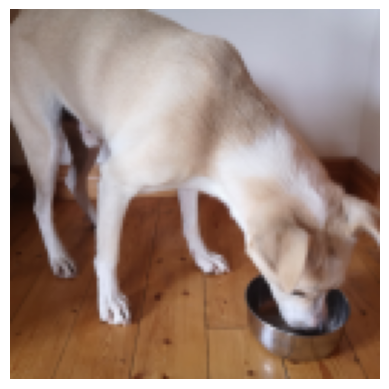

In [33]:

# Check if the images have been loaded correctly
rnd_label = random.choice(list(X_y_live.keys()))
print(f"\nShape of label {rnd_label}: {X_y_live.get(rnd_label).shape}")
plt.imshow(random.choice(X_y_live.get(rnd_label)))
plt.axis("off")
plt.show()

In [99]:
joblib.dump(X_y_live, f'{output_path}/X_y_live.pkl')

['d:\\Projekte\\Coding\\CodeInstitute\\PP5\\outputs/X_y_live.pkl']

In [47]:
from collections import Counter

#SAVE = False

sns.set_style("white")

X_live = np.array([])
y_true = np.array([])

for label in LABELS:
    X_live = np.append(X_live, X_y_live[label]).reshape(INPUT_SHAPE)
    y_true = np.append(y_true, [label] * len(X_y_live[label])).reshape(-1)


print(f"Live data shape: {X_live.shape}")
print("\nLive data stats: \n")

print(pd.DataFrame.from_dict(Counter(y_true), columns=["Amount"], orient="index"))
print("")

# Predict the classes of live images and save the raw predictions in a numpy array
y_pred_raw = model.predict(X_live, verbose=0)
#y_pred_raw = tflite_predict(X_live, *int_data)

# Convert the predictions into a DataFrame with class names
y_pred = pd.DataFrame(np.array([CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)]))

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
# Create a classification report to see the model accuracy
class_report = classification_report(y_true, y_pred, target_names=LABELS)

print("\nConfusion matrix: \n")
print(conf_matrix)
print("\nClassification report: \n")
print(class_report)

if SAVE:
    joblib.dump(
        f"Confusion matrix:\n\n{conf_matrix.to_string()} \n\nClassification report:\n\n {class_report}",
        f"{mod}/live_class_report_{v}.pkl",
    )

Live data shape: (356, 128, 128, 3)

Live data stats: 

        Amount
fin        102
iris       109
smilla     145


Confusion matrix: 

                 Predicted fin  Predicted iris  Predicted smilla
Actually fin               101               1                 0
Actually iris                5             101                 3
Actually smilla              0              35               110

Classification report: 

              precision    recall  f1-score   support

         fin       0.95      0.99      0.97       102
        iris       0.74      0.93      0.82       109
      smilla       0.97      0.76      0.85       145

    accuracy                           0.88       356
   macro avg       0.89      0.89      0.88       356
weighted avg       0.90      0.88      0.88       356



#### Live data precision heatmap

d:\Projekte\Coding\CodeInstitute\PP5\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


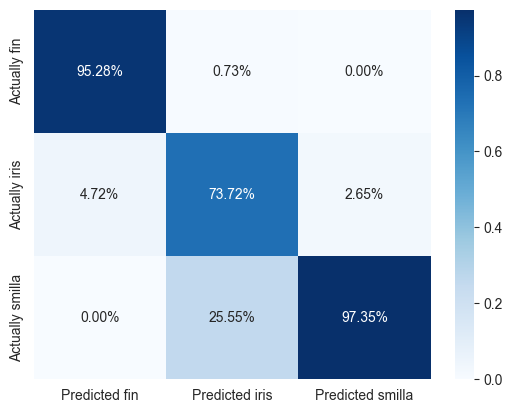

In [48]:
# Show precision in heat map
c_m = pd.DataFrame(confusion_matrix(y_true, y_pred), index=idx, columns=col)
sns.heatmap(c_m / np.sum(c_m), annot=True, fmt=".2%", cmap="Blues")

if SAVE:
    plt.savefig(f"{mod}/pred_live_precision_heatmap_{v}.png")
plt.show()

#### Live data classification heatmap

In [49]:
# Prepare classification report for heatmap visualization
class_report = classification_report(
    y_true, y_pred, target_names=LABELS, output_dict=True
)
df_cr = pd.DataFrame.from_dict(class_report)
df_cr.drop(index=["support"], axis=0, inplace=True)
df_cr.drop(columns=["macro avg", "weighted avg", "accuracy"], axis=1, inplace=True)
df_cr = df_cr.apply(lambda x: x * 100)

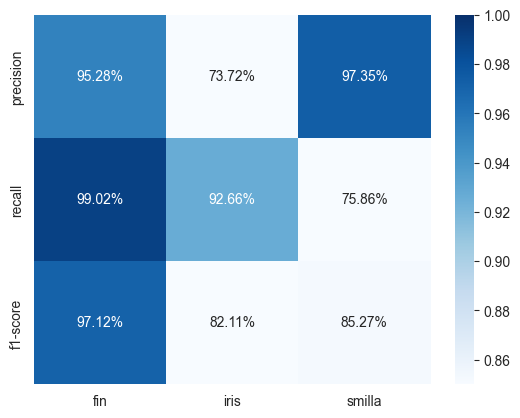

In [50]:
# Show classification in heat map
sns.heatmap(df_cr / 100, annot=True, fmt=".2%", cmap="Blues", vmin=0.85, vmax=1)

if SAVE:
    plt.savefig(f"{mod}/pred_live_classification_heatmap_{v}.png")
plt.show()

In [109]:
# Predict class by evaluating images in batches
from collections import Counter
import functools as ft


sns.set_style("whitegrid")

all_class_predictions = {"true": [], "pred": []}
single_errors = {}

# Go through each label in the live data dictionary
for label_name, img_set in X_y_live.items():
    conf_sum = 0
    # How many separate batches should be predicted for each label?
    batch_amount = 1000
    # How many images should be in one batch?
    sample_amount = 3

    # fig, ax = plt.subplots(figsize=(6, 6))

    all_means = []
    all_vars = []
    batch_probas = []
    single_errors[label_name] = {}

    for batch_num in range(0, batch_amount):
        # For each batch: select a random sample
        img_sample = random.sample(range(0, len(img_set)), k=sample_amount)
        img_subset = img_set[[i for i in img_sample]]

        # Make a prediction for the randomly selected image subset of a given label
        #y_pred_raw = model.predict(img_subset, verbose=0)
        y_pred_raw = tflite_predict(img_subset, *int_data)

        # Create a DataFrame with all predicted class names for this batch
        y_pred = [CLASS_DICT[i] for i in np.argmax(y_pred_raw, axis=1)]

        # Calculate all class means based on each prediction for this label
        y_pred_means = np.around(np.mean(y_pred_raw, axis=0), 3)

        # Make final class prediction based on highest mean value
        confidence = max(y_pred_means)
        pred_class_idx = np.argmax(y_pred_means)
        class_guess = CLASS_DICT[pred_class_idx]

        current_batch_preds = y_pred_raw[:, LABELS.index(label_name)]

        # Plot a graph for the current batch showing confidence for each image
        # ax.step(x=range(1, sample_amount + 1), y=current_batch_preds, where="mid")
        # legend_str = '...' if batch_amount > 20 else ''
        # ax.legend(
        #     [legend_str if legend_str and i == 20 else f"Batch {i}" for i in range(1, min(batch_amount, 20) + 1)],
        #     loc="upper right",
        #     bbox_to_anchor=(0.7, 0.0, 0.6, 1),
        # )
        
        
        # Save confidence values for each picture in each batch for the current label
        batch_probas.append(current_batch_preds)

        # Display the results for the current batch
        current_batch_errors = dict(Counter([i for i in y_pred if i != label_name]))
        for key in current_batch_errors.keys():
            if single_errors[label_name].get(key):
                single_errors[label_name][key] += int(current_batch_errors[key])
            else:
                single_errors[label_name][key] = int(current_batch_errors[key])

        # Save all predicted and true class names for later comparison
        all_class_predictions["true"].append(label_name)
        all_class_predictions["pred"].append(class_guess)

        # Sum up confidence for all batches
        conf_sum += confidence

    g = f"{Fore.GREEN}"
    r = f"{Fore.RESET}"
    print(
        f'{"#"*75}\n... Made predictions for {g}{batch_amount}{r} batches with '
        f'{g}{sample_amount}{r} images per batch.\n{"#"*75}'
    )
    print(f"\nResults for {g}{label_name.upper()}{r}:\n")
    maj_class = Counter(all_class_predictions["pred"][-1 * batch_amount :]).most_common(
        1
    )[0][0]
    print(f"Overall class prediction for all batches: {g}{maj_class.upper()}{r}")
    print(f"Overall confidence for all batches: {g}{conf_sum/batch_amount}{r}")

    # plt.yticks(np.arange(0, 1.2, 0.1))
    # plt.xticks(np.arange(1, sample_amount + 1, 1))
    # plt.ylabel("Confidence")
    # plt.xlabel("Image nr")
    # #if SAVE:
    # #    plt.savefig(f"{final_model}/live_class_img_probas_{label_name}_{v}.png", bbox_inches='tight')
    # plt.show()

    # fig, ax = plt.subplots(figsize=(12, 5))
    # for c, x in enumerate(batch_probas, start=1):
    #     plot = ax.boxplot(
    #         x,
    #         positions=[c],
    #         widths=0.5,
    #         showmeans=True,
    #         meanline=True,
    #         meanprops={"linestyle": "-", "color": "firebrick", "linewidth": 2},
    #         medianprops={"linestyle": "-", "color": "green", "linewidth": 1.5},
    #     )
    #     ax.legend(
    #         [plot["medians"][0], plot["means"][0]],
    #         ["Median", "Mean"],
    #         loc="upper right",
    #         bbox_to_anchor=(0.6, 0.0, 0.6, 1),
    #     )

    #     ax.set_ylabel("Confidence")
    #     ax.set_xlabel("Batch nr")
    # plt.yticks(np.arange(0, 1.2, 0.1))
    # plt.xticks(np.arange(1, batch_amount + 1, 1))
    SAVE = False
    if SAVE:
        plt.savefig(f"{final_model}/live_class_batch_probas_{label_name}_{v}_{batch_amount}_{sample_amount}.png", bbox_inches='tight')
    plt.show()


###########################################################################
... Made predictions for 1000 batches with 3 images per batch.
###########################################################################

Results for FIN:

Overall class prediction for all batches: FIN
Overall confidence for all batches: 0.9774780024886132
###########################################################################
... Made predictions for 1000 batches with 3 images per batch.
###########################################################################

Results for IRIS:

Overall class prediction for all batches: IRIS
Overall confidence for all batches: 0.9540529982149601
###########################################################################
... Made predictions for 1000 batches with 3 images per batch.
###########################################################################

Results for SMILLA:

Overall class prediction for all batches: SMILLA
Overall confidence for all batches: 0.9349

In [112]:

df_errors = pd.DataFrame.from_dict(single_errors)
df_errors.rename_axis(index=("Misclassified as"), inplace=True)
print(f"Analyzed {sample_amount*batch_amount} images per label in total\n")
print(f"\nErrors during {g}individual{r} image classification:\n")
style_dataframe(df_errors)

idx = [f"Actually {label}" for label in LABELS]
col = [f"Predicted {label}" for label in LABELS]

# Compare both DataFrames in a confusion matrix
conf_matrix = pd.DataFrame(
    confusion_matrix(all_class_predictions["true"], all_class_predictions["pred"]),
    index=idx,
    columns=col,
)

# Create a classification report to see the model accuracy
class_report = classification_report(
    all_class_predictions["true"], all_class_predictions["pred"], target_names=LABELS
)

print(
    f"\n\nErrors during {g}batch{r} classification:\n\nConfusion matrix: \n "
    f"{conf_matrix}\n\nClassification report: \n\n{class_report}"
)

report = (
    f"\nErrors during {g}individual{r} image classification:\n{df_errors}"
    f"\n\nErrors during {g}batch{r} classification:\n\nConfusion matrix: \n "
    f"{conf_matrix}\n\nClassification report: \n\n{class_report}"
)

#if SAVE:
#    joblib.dump(report, f"{output_path}/live_class_report_batches_{v}_50_15.pkl")

Analyzed 3000 images per label in total


Errors during individual image classification:

Misclassified as          FIN         IRIS       SMILLA
----------------------------------------------------------------------
iris                     56.0          nan        153.0
smilla                    nan        101.0          nan
fin                       nan         42.0         25.0


Errors during batch classification:

Confusion matrix: 
                  Predicted fin  Predicted iris  Predicted smilla
Actually fin              1000               0                 0
Actually iris                0             999                 1
Actually smilla              2               7               991

Classification report: 

              precision    recall  f1-score   support

         fin       1.00      1.00      1.00      1000
        iris       0.99      1.00      1.00      1000
      smilla       1.00      0.99      0.99      1000

    accuracy                           1.00      300

### Simulate real-world application

In [31]:
# Predict based on feed-in data
import functools as ft
from skimage.transform import resize
import time

sns.set_style("white")

MIX_MODE = False


# Generator either produces random images from one specific label
# or random images from a random label
def X_gen(X, label=None, mix=False):
    if mix:
        while True:
            rand_lbl = random.choice(LABELS)
            rand_idx = random.randint(0, len(X[rand_lbl]) - 1)
            yield X[rand_lbl][rand_idx], rand_lbl
    else:
        while True:
            rand_idx = random.randint(0, len(X[label]) - 1)
            yield X[label][rand_idx], None


def show_reel(img):
    if random.random() > 0.9:
        img_small = resize(img, (50, 50))
        plt.figure(figsize=(2, 2))
        plt.axis("off")
        plt.imshow(img_small)
        plt.show()


result = {}
# Amount of trials for each label
trial_amount = 500
# Minimum amount of images to be evaluated as one batch; a too low number can
# lead to misclassification due to a high-confidence error early on
img_min = 3
# Minimum accepted confidence threshold
min_confidence = 80
# Max amount of attempts after which the current trial is aborted and the next trial started
max_attempts = 15


if MIX_MODE:
    loop_params = ["run 1", "run 2", "run 3"]
else:
    loop_params = LABELS


for label in loop_params:
    trial_results = []

    # Initialize random generator
    xgen = 
    (X_y_live, label, MIX_MODE)
    #xgen = X_gen(X_y_live, X_test, y_test, label, MI
    # 
    # X_MODE)
    

    for t in range(trial_amount):
        attempt_count = 0
        trial_probas = []
        trial_labels = []
        #start = time.time()
        

        # Run trial until the desired confidence threshold has been reached
        # or until the attempt count has reached max attempts.
        while True:
            attempt_count += 1
            print(attempt_count)
          #  print(f"Label {label}, trial {t}, attempt {attempt_count}")

            img, true_class = next(xgen)

            # ----------- Uncomment to see a reel of currently evaluated images -------
            #show_reel(img)
            # -------------------------------------------------------------------------

            # Prepare image and use model to predict a class
            img = np.expand_dims(img, axis=0)

            # Run [img_min] predictions first and collect data without trying to classify
            #y_pred_sg = model.predict(img, verbose=3)
            y_pred_sg = tflite_predict(img, *int_data)
            # Keep track of all probabilities in the current trial
            trial_probas.append(y_pred_sg)

            if MIX_MODE:
                trial_labels.append(true_class)

            if attempt_count >= img_min:
            #    print("Current mean of the trial: ")
                cur_mean = np.round(np.mean(trial_probas, axis=0), 2).flatten()
            #    print(cur_mean)
                fav_class = np.argmax(cur_mean)

                if MIX_MODE:
                    print(
                        f"Model thinks it's {CLASS_DICT[fav_class]}, it's {true_class}"
                    )

                if (
                    cur_mean[fav_class] > min_confidence / 100
                    or attempt_count > max_attempts
                ):
                    add_info = ""
                    if attempt_count > max_attempts:
                        if MIX_MODE:
                            add_info = f"{f'maj. {Counter(trial_labels).most_common(1)[0]}/{len(trial_labels)}':>20}"
                        print(
                            f'\n{"#"*30}\nCancelling classification attempt after {max_attempts} trials.\n'
                            f'Confidence: {cur_mean[fav_class]:.2f}, tending towards class: {CLASS_DICT[fav_class]}\n{"#"*30}\n'
                        )
                        trial_results.append(
                            [
                                np.nan,
                                f"{f'{CLASS_DICT[fav_class]}?':<13} {add_info}",
                                cur_mean[fav_class],
                            ]
                        )
                        break
                    else:
                        if MIX_MODE:
                            maj_class = Counter(trial_labels).most_common(1)[0]
                            trial_results.append(
                                [
                                    attempt_count,
                                    f"{CLASS_DICT[fav_class]} {maj_class}/{len(trial_labels)}",
                                    cur_mean[fav_class],
                                ]
                            )
                            add_info = f", majority class: {maj_class}"
                        else:
                            trial_results.append(
                                [
                                    attempt_count,
                                    CLASS_DICT[fav_class],
                                    cur_mean[fav_class],
                                ]
                            )

                        print(
                            f'\n{"#"*30}\nClassification complete: {CLASS_DICT[fav_class]}\n '
                            f'Confidence: {cur_mean[fav_class]:.2f}, predicted class: {CLASS_DICT[fav_class]}{add_info}\n{"#"*30}\n'
                        )
                        break


                else:
                    print(
                 #       f"--- Unsure yet: current confidence: {cur_mean[fav_class]:.2f}, tending towards class: {CLASS_DICT[fav_class]}\n"
                    )
        #end = time.time()
        #print(end-start)

    result[label] = trial_results

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 0.99, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

##############################
Classification complete: fin
 Confidence: 1.00, predicted class: fin
##############################

1
2
3

####################

In [32]:
import itertools

for label in loop_params:
    column_list = ["-- Attempts --", "------- Pred. class -------", "-- Confidence --"]
    new_dict = {
        (f"Looping through label {label}:", c): np.array(result[label])[..., i].tolist()
        for i, c in enumerate(column_list)
    }
    df = pd.DataFrame.from_dict(new_dict, orient="index").transpose()
    df.columns = pd.MultiIndex.from_tuples(list(new_dict.keys()))
    print(df)
    #joblib.dump(df, f'{output_path}/100trials.txt')
    print("\n\n")

    with open(f'{output_path}/100trials_{label}_{trial_amount}_{min_confidence}_x_b_1.txt', 'w+') as f:
        f.write(df.to_string())



    Looping through label fin:                                             
                -- Attempts -- ------- Pred. class ------- -- Confidence --
0                            3                         fin              1.0
1                            3                         fin             0.99
2                            3                         fin              1.0
3                            3                         fin              1.0
4                            3                         fin              1.0
..                         ...                         ...              ...
495                          3                         fin              1.0
496                          3                         fin              1.0
497                          3                         fin              1.0
498                          3                         fin              1.0
499                          3                         fin              1.0

[500 rows